In [ ]:
"""Тестирование проводим за период с 18.12.2012 по 29.04.2022, 
т.к. с сайта Мосбиржи доступна подробная статистика по ребалансировкам для этого периода.
Можно сделать с 04.03.2011, но нет инф-ции по капитализации для тестирования фактора Size,
поэтому будут только Momentum, Low volatility и High dividends"""

***Создание свода о ребалансировках наших индексов + цены с дивидендами***

In [ ]:
# Добавить комиссии за ребалансировку!

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import math

In [2]:
rebalancing = pd.read_excel('moex - assets.xlsx', sheet_name='динамика для бэктеста', header=1)
price = pd.read_excel('moex - assets.xlsx', sheet_name='цены', index_col=0).iloc[1:]
price = price.fillna(0)
dividends = pd.read_excel('moex - assets.xlsx', sheet_name='дивиденды').iloc[:, 1:]
Nshares = pd.read_excel('moex - assets.xlsx', sheet_name='количество акций', index_col=0)

In [3]:
# Функция берет столбец с ценами и возвращает столбец с изменениями цен без учета неторгуемых дней
def price_to_changes(price_path, log):
    price_path_f = price_path.copy()
    price_path_f = price_path_f[price_path_f != 0]
    if log == False:
        price_changes = price_path_f / price_path_f.shift(1) - 1
    else:
        price_changes = (price_path_f / price_path_f.shift(1)).apply(lambda x: math.log(x))
    price_changes = price_changes.dropna()
    price_changes = price_changes[price_changes != 0]
    
    return(price_changes)

In [4]:
# Функция берет дивидендную дату и, если дивиденд есть и ГЭП попадает в динамику цен, то находит примерную дату, когда был дивидендный ГЭП
def div_date_to_gap_date(div, div_date, price_changes):
    if not(np.isnan(div)):
        if (div_date >= price_changes.index[2]) and (div_date <= price_changes.index[-1]):
            div_date = price_changes[price_changes.index <= div_date].index[-1]
            possible_gap = price_changes[price_changes.index <= div_date][-3:]
            div_gap_date = possible_gap[possible_gap == possible_gap.min()].index[0]
        else:
            div_gap_date = 'За рамками динамики'
    else:
        div_gap_date = 'Нет дивиденда'
        
    return(div_gap_date)

In [5]:
# Функция добавляет в словарь параметры Моментума с указанным окном
# 'Недостаточная история торгов' - если не хватает истории котировок как минимум на половину окна моментума

def momentum_calc(selection, price, window):
    selection_f = selection.copy()
    window = 365 // 12 * window
    for date in selection_f.keys():
        param_calc = []

        for ticker in selection_f[date]['Актив']:
            dynamics = price[ticker]
            dynamics = dynamics[dynamics.index < date]
            dynamics = dynamics[dynamics.index > date - timedelta(window)]
            dynamics = dynamics[dynamics != 0]
            dif = (date - dynamics.index[0]).days

            if dif < window // 2:
                param_calc.append('Недостаточная история торгов')
            else:
                change = dynamics[-1] / dynamics[0] - 1
                param_calc.append(change)

        selection_f[date]['Momentum_' + str(int(12 / (365 // window))) + "M"] = param_calc
    
    return(selection_f)

In [6]:
# Функция добавляет в словарь параметры Volatility с указанным окном
# 'Недостаточная история торгов' - если не хватает истории котировок как минимум на половину окна Volatility

def volatility_calc(selection, price, window):
    selection_f = selection.copy()
    window = 365 // 12 * window
    for date in selection_f.keys():
        param_calc = []

        for ticker in selection_f[date]['Актив']:
            dynamics = price[ticker]
            dynamics = dynamics[dynamics.index < date]
            dynamics = dynamics[dynamics.index > date - timedelta(window)]
            dynamics = dynamics[dynamics != 0]
            dif = (date - dynamics.index[0]).days

            if dif < window // 2:
                param_calc.append('Недостаточная история торгов')
            else:
                change = price_to_changes(dynamics, log=True)
                vol = change.std() 
                param_calc.append(vol)

        selection_f[date]['Volatility_' + str(int(12 / (365 // window))) + "M"] = param_calc
    
    return(selection_f)

In [7]:
# Size - на момент балансировки: цена акции * кол-во акций
def size_calc(selection, price, Nshares):   
    selection_f = selection.copy()

    for date in selection_f.keys():
        param_calc = []
        for ticker in selection_f[date]['Актив']:
            number_shares = Nshares[Nshares.index <= date].iloc[-1][ticker]
            quote = price[price.index < date].iloc[-1][ticker]
            size = number_shares * quote
            param_calc.append(size)

        selection_f[date]['Size'] = param_calc
    
    return(selection_f)

In [8]:
# див. доходность считаем как сумма дивидендов за предыдущие 12 месяцев / цена акций на дату формирования реестра
def div_return_calc(selection, price, dividends):    
    selection_f = selection.copy()

    for date in selection_f.keys():
        date_year_ago = date - timedelta(365)
        param_calc = []
        for ticker in selection_f[date]['Актив']:
            try:
                divs_frame = dividends[(dividends['Date ' + ticker] < date) & (dividends['Date ' + ticker] > date_year_ago)]\
                                                 [['Date ' + ticker, 'Divs ' + ticker]].reset_index(drop=True)

                div_return = 0
                for d in range(len(divs_frame)):
                    div_date = divs_frame.iloc[d, 0]
                    div_value = divs_frame.iloc[d, 1]
                    stock_price = price[price.index == div_date][ticker].iloc[0]
                    if not np.isnan(stock_price) and stock_price != 0:
                        div_return += div_value / stock_price    
                param_calc.append(div_return)
            except:
                param_calc.append(0)
            
        selection_f[date]['Dividends'] = param_calc
        
    return(selection_f)

In [265]:
# Функция забирает словарь с ребалансировками (напротив актива True или False для каждой даты)
# и стратегию из словаря. Для нее выводится динамика, нормированная к 1
# Если moex=True, делает бэктест для всей выборки из moex
def portfolio_path(final_select, strat, price, moex, weighing):
    portfolio_dynamics = pd.DataFrame({'Динамика': [1]}, index=[list(final_select.keys())[0]])
    for Ndate in range(len(list(final_select.keys()))):
        open_date = list(final_select.keys())[Ndate]
        if Ndate != len(list(final_select.keys())) - 1:
            close_date = list(final_select.keys())[Ndate + 1]
        else:
            close_date = end_date
        if not moex:
            selected_assets = final_select[open_date]['Актив'][final_select[open_date][strat]].to_list()
        else:
            selected_assets = final_select[open_date]['Актив'].to_list()

        portfolio_prices = price[selected_assets]
        portfolio_prices = portfolio_prices[portfolio_prices.index >= open_date]
        portfolio_prices = portfolio_prices[portfolio_prices.index <= close_date]
        portfolio_prices = (portfolio_prices / portfolio_prices.shift(1) - 1).dropna()

        Nassets = len(selected_assets)
        
        #Разные виды взвешивания - по волатильности, если аргумент 'vol_reverse', равные веса, если 'equal'
        if weighing  == 'equal':
            weights = [1 / Nassets for x in range(Nassets)]
        if weighing  == 'vol_reverse':
            vols = []
            port_path = price[selected_assets]
            port_path = port_path[port_path.index < open_date]
            port_path = port_path[port_path.index > (open_date - timedelta(90))]
            for share in list(port_path.columns):
                asset_path = port_path[share]
                asset_path = asset_path[asset_path != 0]
                asset_path = (asset_path / asset_path.shift(1)).apply(lambda x: math.log(x)).dropna()
                asset_path = asset_path[asset_path != 0]
                std = asset_path.std()
                vols.append(std)
            vol_reverse = [1 / x for x in vols]
            sum_vols = sum(vol_reverse)
            weights = [x / sum_vols for x in vol_reverse]
        
        portfolio_price = portfolio_prices.iloc[:, 0] * weights[0]
        for asset in range(1, Nassets):
            portfolio_price = portfolio_price + portfolio_prices.iloc[:, asset] * weights[asset]

        portfolio_price = portfolio_price[portfolio_price != 0]

        for obs in range(len(portfolio_price)):
            index = portfolio_price.index[obs]
            value = (portfolio_price[obs] + 1) * portfolio_dynamics.iloc[-1, 0]
            portfolio_dynamics = portfolio_dynamics.append(pd.DataFrame({'Динамика': [value]}, index=[index]))
            
    return(portfolio_dynamics)

In [191]:
# Функция берет историю цен и рассчитывает макс. просадку
def max_drawdown(path):
    current_max = strat_path[0]
    drowdown = 0
    max_drodown = 0
    for obs in strat_path:
        drowdown = obs / current_max - 1
        if drowdown < max_drodown:
            max_drodown = drowdown
        if drowdown > 0:
            current_max = obs
    
    return(max_drodown)

In [9]:
# Добавим в цену дивиденды. Все тикеры из таблицы с ценами должны быть в таблице с дивидендами, иначе выдаст ошибку.

price_first = price.copy()
tax = 0.13

tickers = price.columns.tolist()
for ticker in tickers:
    divs = dividends[['Date ' + ticker, 'Divs ' + ticker]]
    price_path = price[ticker].copy()
    price_changes = price_to_changes(price_path, log=False)
    for i in range(len(divs)):
        div_date = divs.iloc[i, 0]
        div = divs.iloc[i, 1]
        div_gap_date = div_date_to_gap_date(div, div_date, price_changes)
        if div_gap_date == 'Нет дивиденда':
            break
        if div_gap_date == 'За рамками динамики':
            continue
        else:
            price_value = price_path[(price_path.index >= div_gap_date) & (price_path != 0)][0]
            price_path[(price_path.index >= div_gap_date) & (price_path != 0)] *= (div * (1 - tax) / price_value + 1)
    price[ticker] = price_path

In [10]:
# Частота ребалансировки (в месяцах)
freq = 3
freq_days = freq * 30
# Указываем окно для бэктеста (динамика)
# start_date должна быть на год больше, чем минимальная дата в котировках (для подсчета дивидендов за год)
# или freq месяцев больше, если не считаем фактор дивидендов
start_date = pd.to_datetime('18.12.2012')
end_date = pd.to_datetime('29.04.2022')

In [11]:
last_reb_date = start_date - timedelta(freq_days)
ac_reb_date = start_date
# min_days - столько дней должны торговаться половина компаний из индекса с момента последней ребалансировки
min_days = round(freq * 30 * 5 / 7 * 0.3)

In [12]:
# В словарь moex_rebs запишем по датам ребалансировок из нашего периода актуальные акции - Universe
universe1 = rebalancing.columns[(rebalancing.columns <= start_date).sum() - 1]
moex_rebs = {universe1 : rebalancing[universe1][[x in tickers for x in rebalancing[universe1]]].tolist()}
reb_dates = rebalancing.columns[(rebalancing.columns > start_date) & (rebalancing.columns < end_date)]
for reb_date in reb_dates:
    moex_rebs[reb_date] = rebalancing[reb_date][[x in tickers for x in rebalancing[reb_date]]].tolist()

In [13]:
# Ребалансировки индекса со списком активов, которые торговались в дату ребалансировки
real_rebs = {}
while ac_reb_date < end_date:

    moex_date = list(moex_rebs.keys())[sum([x <= ac_reb_date for x in list(moex_rebs.keys())]) - 1]
    ac_universe = moex_rebs[moex_date]
    not_trading = []

    Ntrade = 0
    Ntrade_last = 0
    for ticker in ac_universe:
        price_universe = price[ticker][price[ticker] != 0]
        price_universe = price_universe[price_universe.index <= ac_reb_date]
        price_universe = price_universe[price_universe.index >= last_reb_date]
        change_universe = (price_universe / price_universe.shift(1)).dropna()
        trade_days = (change_universe != 1).sum()
        if trade_days >= min_days:
            Ntrade += 1
        if change_universe[-1] != 1:
            Ntrade_last += 1
        else:
            not_trading.append(ticker)

    if Ntrade / len(ac_universe) >= 0.5:
        if Ntrade_last / len(ac_universe) >= 0.5:
            ac_universe = [x for x in ac_universe if x not in not_trading]
            real_rebs[ac_reb_date] = ac_universe
            last_reb_date = ac_reb_date
            ac_reb_date = ac_reb_date + timedelta(freq_days)
        else:
            ac_reb_date = ac_reb_date + timedelta(1)
    
    else:
        ac_reb_date = ac_reb_date + timedelta(freq_days)


***Расчет значений стратегий***

In [14]:
# В каждую дату ребалансировки положим датафрейм, куда будем складывать параметры стратегий через функции
selection = {}
for i in real_rebs.keys():
    selection[i] = pd.DataFrame(real_rebs[i], columns=['Актив'])

In [15]:
# Добавляем Моментум (можно несколько раз с разными окнами)
# windowM - окно в месяцах
windowM = 3
selection = momentum_calc(selection, price, windowM)

In [16]:
# Добавляем Volatility (можно несколько раз с разными окнами)
# windowV - окно в месяцах
windowV = 12
selection = volatility_calc(selection, price, windowV)

In [17]:
# Добавляем Size
selection = size_calc(selection, price, Nshares)

In [18]:
# Добавляем Dividends
selection = div_return_calc(selection, price_first, dividends)

***Отбор компаний по рассчитанным параметрам***

In [19]:
# Моментум и дивиденды прямо влияют на ожидаемую дох-ть, размер и волатильность - обратно, согласно предположениям
mom_direction = True
vol_direction = False
size_direction = False
div_direction = True

In [21]:
# Можно пробовать разные комбинации стратегий и кол-ва отбираемых из вселенной компаний.
# Для этого для каждой стратегии сначала вводим кол-во комбинаций, которые хотим протестировать,
# А затем для каждой комбинации - сколько компаний будем отбирать из вселенной
parameters = list(selection[list(selection.keys())[0]].columns[1:])
N_select = {}
for param in parameters:
    N_comb = int(input('Введите количество комбинаций для стратегии ' + param))
    list_comb = []
    for i in range(N_comb):
        comb = int(input('Введите количество отбираемых компаний для комбинации '\
                        + str(i+1) + ', для стратегии '+ param))
        list_comb.append(comb)
    N_select[param] = list_comb
    

Введите количество комбинаций для стратегии Momentum_3M1
Введите количество отбираемых компаний для комбинации 1, для стратегии Momentum_3M10
Введите количество комбинаций для стратегии Volatility_12M1
Введите количество отбираемых компаний для комбинации 1, для стратегии Volatility_12M10
Введите количество комбинаций для стратегии Size1
Введите количество отбираемых компаний для комбинации 1, для стратегии Size10
Введите количество комбинаций для стратегии Dividends1
Введите количество отбираемых компаний для комбинации 1, для стратегии Dividends10


In [22]:
final_select = {}
for date in selection.keys():
    final_select[date] = pd.DataFrame()
    select = selection[date]
    final_select[date]['Актив'] = select['Актив']
    
    for strat in list(select.columns)[1:]:
        select_strat = select[['Актив', strat]]
        select_strat = select_strat[select_strat[strat] != 'Недостаточная история торгов']
        if strat.__contains__('Momentum'):
            direction = mom_direction
        elif strat.__contains__('Volatility'):    
            direction = vol_direction
        elif strat.__contains__('Size'):     
            direction = size_direction
        elif strat.__contains__('Dividends'):    
            direction = div_direction
            
        # Для Size капитализацию по прив. акциям прибавляем к обычным, если они есть в выборке (обычно представлены обе)
        if strat == 'Size':
            for ticker in list(select_strat['Актив']):
                short = ticker[:-1]
                if short in list(select_strat['Актив']):
                    select_strat.loc[select_strat['Актив'] == short, 'Size'] +=\
                    select_strat.loc[select_strat['Актив'] == ticker, 'Size'].iloc[0]
                    select_strat = select_strat.loc[select_strat['Актив'] != ticker]

        select_strat = select_strat.sort_values(strat, ascending=not direction).reset_index(drop=True)

        for n_comp in N_select[strat]:
            top_assets = list(select_strat.iloc[:n_comp]['Актив'])
            top_assets = [x in top_assets for x in list(select['Актив'])]
            final_select[date][strat + '_' + str(n_comp) + 'Comp'] = top_assets

***Динамика портфелей***

In [266]:
# В словарь backtesting сложим динамику всех стратегий
backtesting = {}
for strat in list(final_select[list(final_select.keys())[0]].columns[1:]):
    backtest_path = portfolio_path(final_select, strat, price, moex=False, weighing='vol_reverse')
    backtesting[strat] = backtest_path
backtest_path_moex = portfolio_path(final_select, strat, price, moex=True, weighing='vol_reverse')
backtesting['Moex_NTR'] = backtest_path_moex

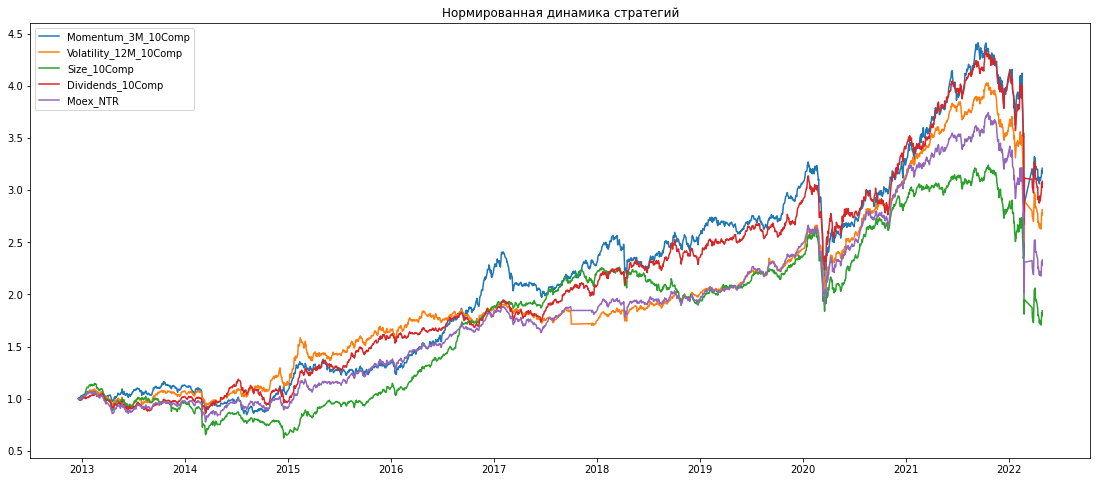

In [267]:
# Графики
import matplotlib.pyplot as plt
plt.figure(figsize=(19, 8))
plt.title('Нормированная динамика стратегий')
for strategy in list(backtesting.keys()):
    plt.plot(backtesting[strategy])
plt.legend(list(backtesting.keys()))
plt.show()

In [ ]:
# Статистики

In [268]:
stats = pd.DataFrame()

In [269]:
for strategy in list(backtesting.keys()):
    strat_path = backtesting[strategy]['Динамика']
    ret = strat_path[-1] / strat_path[0] - 1
    term = round((end_date - start_date).days / 365, 2)
    # return с учетом реинвестирования в %гг
    ret_per_year = (ret + 1) ** (1 / term) - 1
    vol = price_to_changes(strat_path, True).std()
    vol_per_year = vol * (256 ** (1 / 2))
    # Шарп без вычета безрисковой ставки! Можем это сделать, т.к. один и тот же период бэктеста всех стратегий, rf одинаковая и
    # можно сравнивать без него
    sharp = ret_per_year / vol_per_year
    minimum = strat_path.min()
    maximum = strat_path.max()
    maximum_drawdown = max_drawdown(strat_path)
    
    stats[strategy] = [ret, ret_per_year, vol_per_year, sharp, minimum, maximum, maximum_drawdown]
    
stats.index = ['Доходность', 'Доходность гг. реинвест.', 'Волатильность %гг', 'Коэф-нт Шарпа без rf',\
               'Минимум', 'Максимум', 'Макс. просадка']

In [270]:
stats

,Momentum_3M_10Comp,Volatility_12M_10Comp,Size_10Comp,Dividends_10Comp,Moex_NTR
Доходность,2.210911,1.812913,0.843031,2.085962,1.330643
Доходность гг. реинвест.,0.132581,0.116698,0.067428,0.127793,0.094506
Волатильность %гг,0.237196,0.176052,0.203158,0.196185,0.200362
Коэф-нт Шарпа без rf,0.558951,0.662859,0.331899,0.651392,0.471680
Минимум,0.845889,0.904758,0.622121,0.860063,0.776373
Максимум,4.415302,4.029030,3.240354,4.349230,3.745119
Макс. просадка,-0.463440,-0.378658,-0.473200,-0.385018,-0.462582
